In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'zh'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese-en'


In [4]:
# Parameters
model_size = "13b"
target_lang = "zh"
input_lang = "zh"
type = "tuned-chinese"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [6]:

llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
    
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"../tuned-lens/my_lenses/chinese/{model_size}").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
if type == 'tuned-chinese-en':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"../tuned-lens/my_lenses/chinese/{model_size}").to("cuda")
    out_dir = f'./visuals/tuned-chinese-en'
    latent = 'en'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=5120, out_features=32000, bias=False)
)
U torch.Size([32000, 5120]) weights torch.Size([1, 5120])


0.11461826413869858


In [8]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      df_en_target_input = df_en_target.copy()
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_target_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_{latent}_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for zh 139 of 139 are single tokens
final length of df_zh_zh_zh: 139


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

  1%|██▊                                                                                                                                                                                                    | 2/139 [00:00<00:09, 14.56it/s]

  3%|█████▋                                                                                                                                                                                                 | 4/139 [00:00<00:09, 14.79it/s]

  4%|████████▌                                                                                                                                                                                              | 6/139 [00:00<00:08, 15.10it/s]

  6%|███████████▍                                                                                                                                                                                           | 8/139 [00:00<00:08, 15.14it/s]

  7%|██████████████▏                                                                                                                                                                                       | 10/139 [00:00<00:08, 15.04it/s]

  9%|█████████████████                                                                                                                                                                                     | 12/139 [00:00<00:08, 15.26it/s]

 10%|███████████████████▉                                                                                                                                                                                  | 14/139 [00:00<00:08, 15.15it/s]

 12%|██████████████████████▊                                                                                                                                                                               | 16/139 [00:01<00:08, 15.33it/s]

 13%|█████████████████████████▋                                                                                                                                                                            | 18/139 [00:01<00:07, 15.21it/s]

 14%|████████████████████████████▍                                                                                                                                                                         | 20/139 [00:01<00:07, 15.34it/s]

 16%|███████████████████████████████▎                                                                                                                                                                      | 22/139 [00:01<00:07, 15.29it/s]

 17%|██████████████████████████████████▏                                                                                                                                                                   | 24/139 [00:01<00:07, 15.44it/s]

 19%|█████████████████████████████████████                                                                                                                                                                 | 26/139 [00:01<00:07, 15.23it/s]

 20%|███████████████████████████████████████▉                                                                                                                                                              | 28/139 [00:01<00:07, 15.37it/s]

 22%|██████████████████████████████████████████▋                                                                                                                                                           | 30/139 [00:01<00:07, 15.50it/s]

 23%|█████████████████████████████████████████████▌                                                                                                                                                        | 32/139 [00:02<00:06, 15.38it/s]

 24%|████████████████████████████████████████████████▍                                                                                                                                                     | 34/139 [00:02<00:06, 15.49it/s]

 26%|███████████████████████████████████████████████████▎                                                                                                                                                  | 36/139 [00:02<00:06, 15.39it/s]

 27%|██████████████████████████████████████████████████████▏                                                                                                                                               | 38/139 [00:02<00:06, 15.50it/s]

 29%|████████████████████████████████████████████████████████▉                                                                                                                                             | 40/139 [00:02<00:06, 15.58it/s]

 30%|███████████████████████████████████████████████████████████▊                                                                                                                                          | 42/139 [00:02<00:06, 15.61it/s]

 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                       | 44/139 [00:02<00:06, 15.64it/s]

 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                    | 46/139 [00:02<00:05, 15.64it/s]

 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 48/139 [00:03<00:05, 15.63it/s]

 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                              | 50/139 [00:03<00:05, 15.58it/s]

 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                            | 52/139 [00:03<00:05, 15.56it/s]

 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 54/139 [00:03<00:05, 15.58it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 56/139 [00:03<00:05, 15.54it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 58/139 [00:03<00:05, 15.51it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 60/139 [00:03<00:05, 15.54it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 62/139 [00:04<00:04, 15.50it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 64/139 [00:04<00:04, 15.57it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 66/139 [00:04<00:04, 15.55it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 68/139 [00:04<00:04, 15.56it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 70/139 [00:04<00:04, 15.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 72/139 [00:04<00:04, 15.54it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 74/139 [00:04<00:04, 15.60it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 76/139 [00:04<00:04, 15.63it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 78/139 [00:05<00:03, 15.60it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 80/139 [00:05<00:03, 15.51it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 82/139 [00:05<00:03, 15.51it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 84/139 [00:05<00:03, 15.54it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 86/139 [00:05<00:03, 15.47it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 88/139 [00:05<00:03, 15.53it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 90/139 [00:05<00:03, 15.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 92/139 [00:05<00:03, 15.49it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 94/139 [00:06<00:02, 15.49it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 96/139 [00:06<00:02, 15.48it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 98/139 [00:06<00:02, 15.49it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 100/139 [00:06<00:02, 15.53it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 102/139 [00:06<00:02, 15.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 104/139 [00:06<00:02, 15.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 106/139 [00:06<00:02, 15.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 108/139 [00:06<00:01, 15.58it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 110/139 [00:07<00:01, 15.46it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 112/139 [00:07<00:01, 15.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 114/139 [00:07<00:01, 15.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 116/139 [00:07<00:01, 15.62it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 118/139 [00:07<00:01, 15.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 120/139 [00:07<00:01, 15.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 122/139 [00:07<00:01, 15.59it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 124/139 [00:08<00:00, 15.51it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 126/139 [00:08<00:00, 15.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 128/139 [00:08<00:00, 15.63it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 130/139 [00:08<00:00, 15.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 132/139 [00:08<00:00, 15.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 134/139 [00:08<00:00, 15.72it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 136/139 [00:08<00:00, 15.75it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 138/139 [00:08<00:00, 15.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:08<00:00, 15.50it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df["prompt"][0]

'中文: "河" - 中文: "河"\n中文: "南" - 中文: "南"\n中文: "云" - 中文: "云"\n中文: "场" - 中文: "场"\n中文: "汉" - 中文: "'

In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    hd= []
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
        hd+=[lens.transform_hidden(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hd)
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:01,  1.36s/it]

2it [00:01,  1.40it/s]

3it [00:01,  2.06it/s]

4it [00:02,  2.65it/s]

5it [00:02,  3.15it/s]

6it [00:02,  3.55it/s]

7it [00:02,  3.87it/s]

8it [00:02,  4.10it/s]

9it [00:03,  4.24it/s]

10it [00:03,  4.08it/s]

11it [00:03,  4.23it/s]

12it [00:03,  4.12it/s]

13it [00:04,  4.16it/s]

14it [00:04,  4.21it/s]

15it [00:04,  4.00it/s]

16it [00:04,  4.22it/s]

17it [00:05,  4.16it/s]

18it [00:05,  4.13it/s]

19it [00:05,  4.14it/s]

20it [00:05,  4.20it/s]

21it [00:05,  4.31it/s]

22it [00:06,  4.37it/s]

23it [00:06,  4.38it/s]

24it [00:06,  4.24it/s]

25it [00:06,  4.27it/s]

26it [00:07,  4.38it/s]

27it [00:07,  4.55it/s]

28it [00:07,  4.63it/s]

29it [00:07,  4.52it/s]

30it [00:07,  4.52it/s]

31it [00:08,  4.61it/s]

32it [00:08,  4.49it/s]

33it [00:08,  4.53it/s]

34it [00:08,  4.66it/s]

35it [00:09,  4.77it/s]

36it [00:09,  4.76it/s]

37it [00:09,  4.57it/s]

38it [00:09,  4.64it/s]

39it [00:09,  4.68it/s]

40it [00:10,  4.69it/s]

41it [00:10,  4.69it/s]

42it [00:10,  4.67it/s]

43it [00:10,  4.75it/s]

44it [00:10,  4.70it/s]

45it [00:11,  4.66it/s]

46it [00:11,  4.73it/s]

47it [00:11,  4.81it/s]

48it [00:11,  4.68it/s]

49it [00:12,  4.59it/s]

50it [00:12,  4.66it/s]

51it [00:12,  4.62it/s]

52it [00:12,  4.60it/s]

53it [00:12,  4.66it/s]

54it [00:13,  4.64it/s]

55it [00:13,  4.36it/s]

56it [00:13,  4.48it/s]

57it [00:13,  4.47it/s]

58it [00:14,  4.36it/s]

59it [00:14,  4.34it/s]

60it [00:14,  3.94it/s]

61it [00:14,  3.95it/s]

62it [00:15,  4.12it/s]

63it [00:15,  4.10it/s]

64it [00:15,  4.28it/s]

65it [00:15,  4.36it/s]

66it [00:15,  4.52it/s]

67it [00:16,  4.55it/s]

68it [00:16,  4.57it/s]

69it [00:16,  4.60it/s]

70it [00:16,  4.59it/s]

71it [00:17,  4.44it/s]

72it [00:17,  4.42it/s]

73it [00:17,  4.36it/s]

74it [00:17,  4.29it/s]

75it [00:17,  4.47it/s]

76it [00:18,  4.29it/s]

77it [00:18,  4.37it/s]

78it [00:18,  4.28it/s]

79it [00:18,  4.08it/s]

80it [00:19,  4.25it/s]

81it [00:19,  4.15it/s]

82it [00:19,  4.29it/s]

83it [00:19,  4.33it/s]

84it [00:20,  4.22it/s]

85it [00:20,  4.37it/s]

86it [00:20,  4.30it/s]

87it [00:20,  4.28it/s]

88it [00:21,  4.41it/s]

89it [00:21,  4.28it/s]

90it [00:21,  4.39it/s]

91it [00:21,  4.44it/s]

92it [00:21,  4.28it/s]

93it [00:22,  4.40it/s]

94it [00:22,  4.48it/s]

95it [00:22,  4.48it/s]

96it [00:22,  4.49it/s]

97it [00:23,  4.49it/s]

98it [00:23,  4.46it/s]

99it [00:23,  4.45it/s]

100it [00:23,  4.47it/s]

101it [00:23,  4.46it/s]

102it [00:24,  4.35it/s]

103it [00:24,  4.47it/s]

104it [00:24,  4.56it/s]

105it [00:24,  4.63it/s]

106it [00:25,  4.66it/s]

107it [00:25,  4.77it/s]

108it [00:25,  4.46it/s]

109it [00:25,  4.49it/s]

110it [00:25,  4.61it/s]

111it [00:26,  4.62it/s]

112it [00:26,  4.57it/s]

113it [00:26,  4.67it/s]

114it [00:26,  4.51it/s]

115it [00:27,  4.53it/s]

116it [00:27,  4.59it/s]

117it [00:27,  4.65it/s]

118it [00:27,  4.58it/s]

119it [00:27,  4.54it/s]

120it [00:28,  4.53it/s]

121it [00:28,  4.40it/s]

122it [00:28,  4.49it/s]

123it [00:28,  4.35it/s]

124it [00:29,  4.47it/s]

125it [00:29,  4.46it/s]

126it [00:29,  4.55it/s]

127it [00:29,  4.53it/s]

128it [00:29,  4.45it/s]

129it [00:30,  4.21it/s]

130it [00:30,  4.13it/s]

131it [00:30,  4.35it/s]

132it [00:30,  4.25it/s]

133it [00:31,  4.24it/s]

134it [00:31,  4.24it/s]

135it [00:31,  4.18it/s]

136it [00:31,  4.34it/s]

137it [00:32,  4.20it/s]

138it [00:32,  4.34it/s]

139it [00:32,  4.38it/s]

139it [00:32,  4.28it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


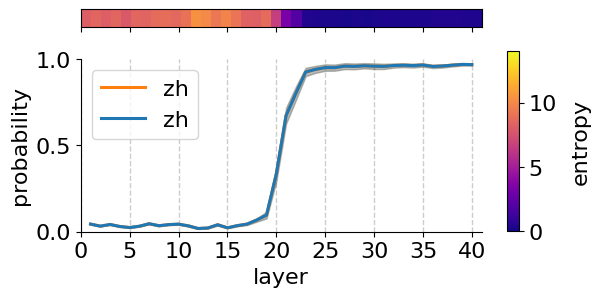

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

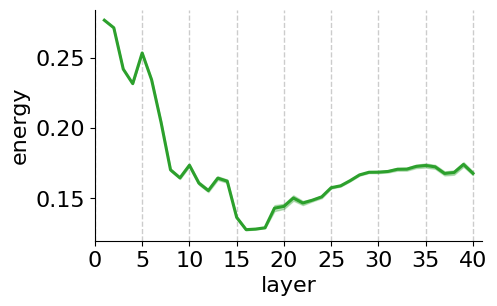

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')